# Assignment 7

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Plotting defaults (clean, readable)
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
})

# For reproducibility
rng = np.random.default_rng(7) 

Here we introduce some basic parameters:

In [ ]:
I   = 1.0    # exchange coupling (sets the energy unit)
muB = 1.0    # magnetic moment per spin
B   = 0.0    # external field

# Tunable configuration
FAST = True  # set False for better statistics (but slower!)

# Simulation lengths
if FAST:
    SWEEPS = 2500        # total sweeps per temperature
    BURN   = 800         # burn-in sweeps (discarded)
else:
    SWEEPS = 8000
    BURN   = 2500

First, we need a function that computes the energy of our spin lattice.
With the following function, we compute the Hamiltonian:

$$ H(\{s_i\}) \;=\; -\mu_B B \sum_{i=1}^{N} s_i \;-\; \frac{I}{2}\sum_{i=1}^{N}\;\sum_{j\in\Lambda_i} s_i s_j,\qquad s_i=\pm 1, $$

We will assume that the lattice is **fully** occupied.
Indeed, we implement the **lattice configuration** in a 2D NumPy array `spins` of shape `(S, S)` with entries in `{+1, −1}`. Each entry represents the Ising spin at lattice site `(i, j)` (row `i`, column `j`).

Using this array, in order to get the total energy of the spin lattice, we split the computation in two parts: we first compute the contribution that (**field**) that comes from the self-energies (the first one in the formula abova), and then we compute the interaction contribution (**inter**).

We consider spins on an $S\times S$ lattice $N=S^2$, 

Notice that we will be assuming two key hypotheses: 
* interactions take place only among the four nearest neighbours;
* we assume periodic boundary conditions.

Below we implement these two properties via the `np.roll` function.
This function, for instance, acts as
`np.roll(spins, +1, axis=0)[i,j] = spins[(i-1) % S, j]`
and
`np.roll(spins, -1, axis=1)[i,j] = spins[i, (j+1) % S]`.
So a roll by $\pm 1$ along an axis gives the **up/down/left/right** neighbour fields under the periodic boundary conditions.

Concretely, below we introduce
```python
up    = np.roll(spins, +1, axis=0)
down  = np.roll(spins, -1, axis=0)
left  = np.roll(spins, +1, axis=1)
right = np.roll(spins, -1, axis=1)
```

and the interactions are computed via

```python
neigh_sum = up + down + left + right
inter = -0.5 * I * np.sum(spins * neigh_sum)
```




In [2]:
def total_energy(spins, I=1.0, B=0.0, muB=1.0):
    '''Compute the total energy H of a 2D Ising configuration with periodic boundaries.

    Parameters
    ----------
    spins : ndarray of shape (S, S), dtype int8 or int
        Lattice of spins taking values in {+1, -1}. We assume a **square** lattice.
    I : float, default 1.0
        Nearest–neighbour exchange coupling. Positive I favours alignment (ferromagnet).
    B : float, default 0.0
        External magnetic field (uniform). Units are such that k_B = 1.
    muB : float, default 1.0
        Magnetic moment per spin.

    Returns
    -------
    energy : float
        Total energy H({s_i}) = - muB B sum_i s_i - (I/2) sum_{<i,j>} s_i s_j.
    
    '''
    # field term
    field = - muB * B * spins.sum()

    # nearest-neighbour sum via periodic rolls
    up    = np.roll(spins,  1, axis=0)
    down  = np.roll(spins, -1, axis=0)
    left  = np.roll(spins,  1, axis=1)
    right = np.roll(spins, -1, axis=1)
    neigh_sum = up + down + left + right

    # interaction term (1/2 avoids double counting of bonds)
    inter = -0.5 * I * np.sum(spins * neigh_sum)

    return float(field + inter)

...and we introduce also a function that computes the total magnetisation, as simply the sum of the spins times $\mu_B$:

In [3]:
def magnetisation(spins, muB=1.0):
    '''Compute the extensive magnetisation M = muB * sum_i s_i.

    Parameters
    ----------
    spins : ndarray (S, S)
        Spin configuration with entries in {+1, -1}.
    muB : float, default 1.0
        Magnetic moment per spin.

    Returns
    -------
    M : float
        Extensive magnetisation. Divide by N=S^2 to obtain per–spin magnetisation.
    '''
    return float(muB * spins.sum())


We can now introduce a function that implements a Metropolis **sweep**, and determines whether we should flip a spin.

The algorithm acts as follows:


1. Draw a random permutation of the $N = S^2$ sites.
2. For each site $(i, j)$, with associated spin $s_{ij}$:
    - Compute the local neighbour sum $s_{\text{neigh}} = \text{sum over the 4 nearest neighbours}$.
    - Compute the energy change for a flip of the spin at the $(i, j)$-th site: $dU = 2 s_{ij} (\mu_B B + I s_{\text{neigh}})$.
    - Accept the flip if $dU \leq 0$; otherwise, accept it with probability $\exp(-dU/T)$.
3. This constitutes one sweep.

Notice that the complexity per sweep is $O(N)$.
Moreover, in order to avoid bias, we introduce stochasticity in deciding the order of lattice scans (this is implemented below by permutating the matrix of spins).

In [4]:
def metropolis_sweep(spins, T, I=1.0, B=0.0, muB=1.0, rng=None):
    '''Perform one Metropolis sweep visiting each site once in random order.

    Parameters
    ----------
    spins : ndarray (S, S), modified in place
        The current spin configuration (±1). The array is updated in place.
    T : float
        Temperature (k_B = 1). Must be > 0 for meaningful acceptance probabilities.
    I, B, muB : float
        Model parameters as in `total_energy`.
    rng : numpy.random.Generator or None
        Random number generator. If None, a default generator is created.

    Returns
    -------
    spins : ndarray (S, S)
        The same array reference, possibly with many flipped spins.

    

    '''
    if rng is None:
        rng = np.random.default_rng()

    S = spins.shape[0]
    # random order of all sites
    idx = rng.permutation(S*S)
    for k in idx:
        i, j = divmod(k, S)
        si = spins[i, j]
        # local neighbour sum (manual indexing a touch faster than np.roll here)
        s_neigh = spins[(i+1)%S, j] + spins[(i-1)%S, j] + spins[i, (j+1)%S] + spins[i, (j-1)%S]
        dU = 2.0 * si * (muB * B + I * s_neigh)
        if dU <= 0.0 or rng.random() < math.exp(-dU / T):
            spins[i, j] = -si  # flip accepted
    return spins

We can now define a function that performs many sweeps and records **per–spin** time series $U/N$ and $M/N$ **after** the burn–in (or relaxation) period:

> Note that the function below calls `metropolis_sweep` in a loop, resultin in a complexity $O(N \times \text{sweeps})$.

In [5]:
def run_ising(S=10, T=2.5, sweeps=4000, burn=1000, init="random",
              I=1.0, B=0.0, muB=1.0, rng=None):
    '''Run a full Metropolis simulation and collect per–spin time series after burn–in.

    Parameters
    ----------
    S : int, default 10
        Linear lattice size; total spins N = S^2.
    T : float, default 2.5
        Temperature (k_B = 1).
    sweeps : int, default 4000
        Total number of Metropolis sweeps to perform.
    burn : int, default 1000
        Number of initial sweeps discarded as equilibration (burn–in).
    init : {"random", "aligned"}, default "random"
        Initial state. "aligned" sets all spins to +1; "random" samples each spin ±1.
    I, B, muB : float
        Model parameters as before.
    rng : numpy.random.Generator or None
        RNG for reproducibility.

    Returns
    -------
    UN : ndarray (T_eff,)
        Recorded series of energy per spin U/N for sweeps s = burn, …, sweeps-1.
    MN : ndarray (T_eff,)
        Recorded series of magnetisation per spin M/N for the same sweeps.

    '''
    if rng is None:
        rng = np.random.default_rng()

    N = S*S
    # initial state
    if init == "aligned":
        spins = np.ones((S, S), dtype=np.int8)
    else:
        spins = rng.choice([-1, 1], size=(S, S)).astype(np.int8)

    # measure after burn-in
    UN, MN = [], []
    for s in range(sweeps):
        metropolis_sweep(spins, T=T, I=I, B=B, muB=muB, rng=rng)
        if s >= burn:
            U = total_energy(spins, I=I, B=B, muB=muB)
            M = magnetisation(spins, muB=muB)
            UN.append(U / N)
            MN.append(M / N)
    return np.asarray(UN, dtype=float), np.asarray(MN, dtype=float)

## Energy and magnetisation time series at selected temperatures

We show $U/N$ and $|M|/N$ vs sweep number for a few representative temperatures:

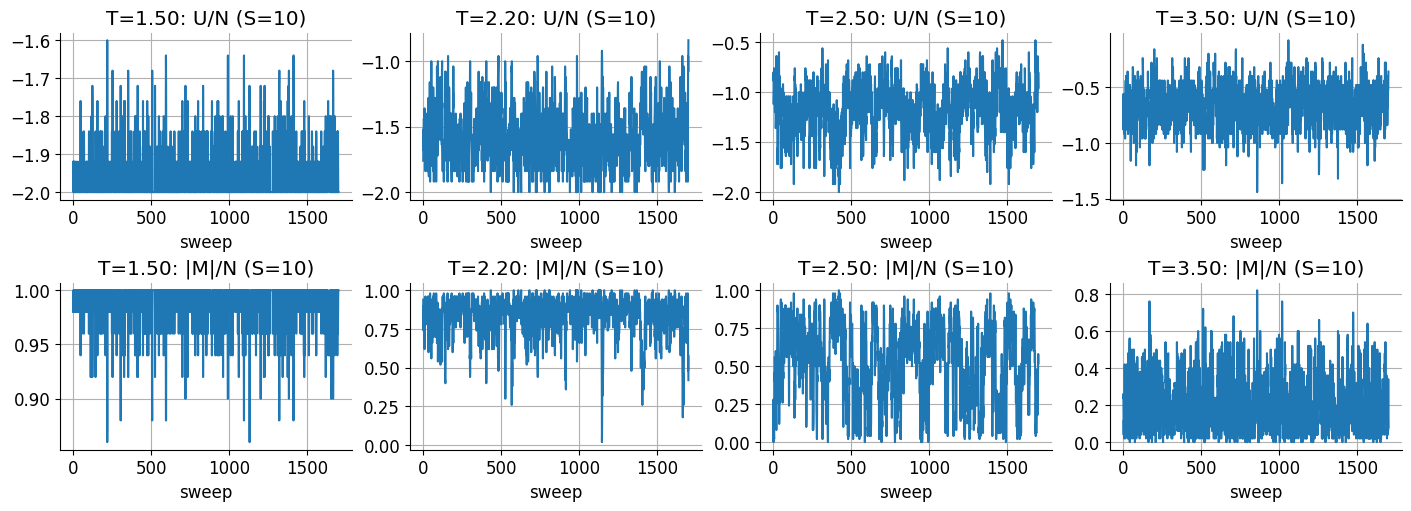

In [9]:
S = 10
Ts_show = [1.5, 2.2, 2.5, 3.5]

fig, axs = plt.subplots(2, len(Ts_show), figsize=(14, 5), constrained_layout=True)

for k, T in enumerate(Ts_show):
    UN, MN = run_ising(S=S, T=T, sweeps=SWEEPS, burn=BURN, init="random", I=I, B=B, muB=muB, rng=rng)
    axs[0, k].plot(UN)
    axs[0, k].set_title(f"T={T:.2f}: U/N (S={S})")
    axs[0, k].set_xlabel("sweep")
    axs[0, k].grid(True)

    axs[1, k].plot(np.abs(MN))
    axs[1, k].set_title(f"T={T:.2f}: |M|/N (S={S})")
    axs[1, k].set_xlabel("sweep")
    axs[1, k].grid(True)

plt.show()

## Mean-field approximation, specific heat and specific magnetic susceptibility

Now, we would like to plot the specific heat $C/N$ and the specific magnetic susceptibility $\chi/N$ for $1\le T\le 4$. These are defined via
$$
	C(T,B,N)=\frac{\sigma_U^2}{T^2},\qquad
	\chi(T,B,N)=\frac{\partial M}{\partial B}=\frac{\sigma_M^2}{T^2}
$$

Thus, we introduce a function that loops over temperatures and returns $\langle U/N\rangle$, $\langle|M|/N\rangle$, and fluctuation estimators $C/N$, $\chi/N$.

In [10]:
def temp_scan(S=10, Ts=None, sweeps=6000, burn=2000, I=1.0, B=0.0, muB=1.0, rng=None):
    '''Scan a temperature grid and estimate thermodynamic observables via fluctuations.

    Parameters
    ----------
    S : int
        Lattice size (N = S^2).
    Ts : array-like or None
        Temperatures to simulate. If None, a default linspace(1.0, 4.0, 16) is used.
    sweeps, burn, I, B, muB, rng : as in `run_ising`.

    Returns
    -------
    UN_mean : ndarray (len(Ts),)
        Monte Carlo estimate of <U/N> at each T.
    MN_abs_mean : ndarray (len(Ts),)
        Estimate of <|M|/N> (absolute value used to avoid Z2 symmetry cancellation).
    Cv : ndarray (len(Ts),)
        Specific heat per spin from fluctuations: C/N = Var(U)/(T^2 N).
    Chi : ndarray (len(Ts),)
        Susceptibility per spin from fluctuations: chi/N = Var(M)/(T^2 N).

    '''
    if rng is None:
        rng = np.random.default_rng()
    if Ts is None:
        Ts = np.linspace(1.0, 4.0, 16)

    N = S*S
    UN_mean, MN_abs_mean, Cv, Chi = [], [], [], []

    for T in Ts:
        UN, MN = run_ising(S=S, T=T, sweeps=sweeps, burn=burn, init="random",
                           I=I, B=B, muB=muB, rng=rng)
        UN_mean.append(UN.mean())
        MN_abs_mean.append(np.abs(MN).mean())  # avoid symmetry sign flips

        # Fluctuation estimators (k_B=1)
        if UN.size > 1:
            varUN = UN.var(ddof=1)
            Cv.append(varUN * N / (T*T))
        else:
            Cv.append(np.nan)

        if MN.size > 1:
            varMN = MN.var(ddof=1)
            Chi.append(varMN * N / (T*T))
        else:
            Chi.append(np.nan)

    return np.asarray(UN_mean, dtype=float), np.asarray(MN_abs_mean, dtype=float), np.asarray(Cv, dtype=float), np.asarray(Chi, dtype=float)


In addition, we also introduce a function that computes the mean–field reference $m$ by solving $m=\tanh\!\big((qI/T)m\big)$ using fixed–point iteration:

In [ ]:
def mf_magnetisation(T, q=4, I=1.0, tol=1e-12, max_iter=2000):
    '''Compute the mean–field magnetisation m(T) at B=0 by fixed–point iteration.

    We solve m = tanh((q I / T) m), where q=4 for a 2D square lattice.

    Parameters
    ----------
    T : float
        Temperature (k_B=1).
    q : int, default 4
        Coordination number (4 for the square lattice).
    I : float, default 1.0
        Exchange coupling.
    tol : float, default 1e-12
        Stopping tolerance for fixed–point differences.
    max_iter : int, default 200000
        Hard cap on iterations.

    Returns
    -------
    m : float
        Fixed–point solution in [0, 1]. For T > T_c^MF (= q I) returns ~0.

    '''
    if T <= 0:
        return 1.0
    m = 1e-6  # small symmetry-breaking seed
    for _ in range(max_iter):
        m_new = math.tanh(q * I * m / T)
        if abs(m_new - m) < tol:
            return float(m_new)
        m = m_new
    return float(m)  

...and we plot them:

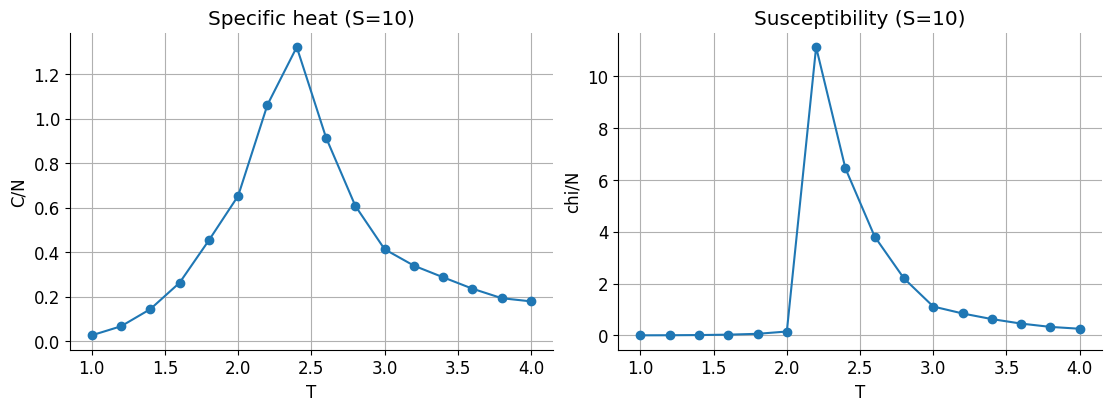

In [ ]:
Ts = np.linspace(1.0, 4.0, 16)
UNm, MNm, Cv, Chi = temp_scan(S=10, Ts=Ts, sweeps=SWEEPS, burn=BURN, I=I, B=B, muB=muB, rng=rng)

# Specific heat and susceptibility
fig, ax = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
ax[0].plot(Ts, Cv, "o-")
ax[0].set_xlabel("T"); ax[0].set_ylabel("C/N"); ax[0].set_title("Specific heat (S=10)"); ax[0].grid(True)

ax[1].plot(Ts, Chi, "o-")
ax[1].set_xlabel("T"); ax[1].set_ylabel("chi/N"); ax[1].set_title("Susceptibility (S=10)"); ax[1].grid(True)

plt.show()

## Finite–size effects

We focus on the critical region and show how the peaks sharpen and shift as the system grows:

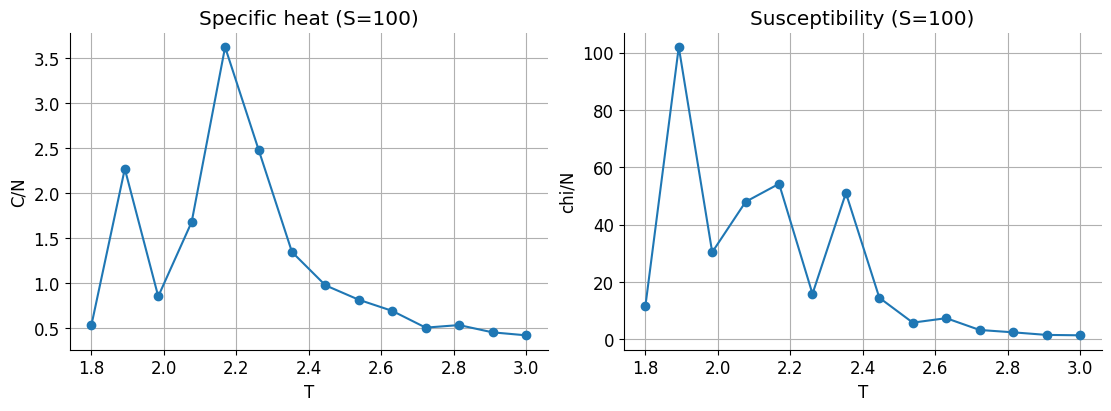

In [13]:
S_big = 100
Ts2 = np.linspace(1.8, 3.0, 14)  # focus near criticality

UNm2, MNm2, Cv2, Chi2 = temp_scan(S=S_big, Ts=Ts2, sweeps=SWEEPS//2 if FAST else SWEEPS, 
                                  burn=BURN//2 if FAST else BURN,
                                  I=I, B=B, muB=muB, rng=rng)

fig, ax = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
ax[0].plot(Ts2, Cv2, "o-")
ax[0].set_xlabel("T"); ax[0].set_ylabel("C/N"); ax[0].set_title(f"Specific heat (S={S_big})"); ax[0].grid(True)

ax[1].plot(Ts2, Chi2, "o-")
ax[1].set_xlabel("T"); ax[1].set_ylabel("chi/N"); ax[1].set_title(f"Susceptibility (S={S_big})"); ax[1].grid(True)

plt.show()

## (Optional) Spin snapshots

For intuition, below are snapshots of the spin configuration at different temperatures:

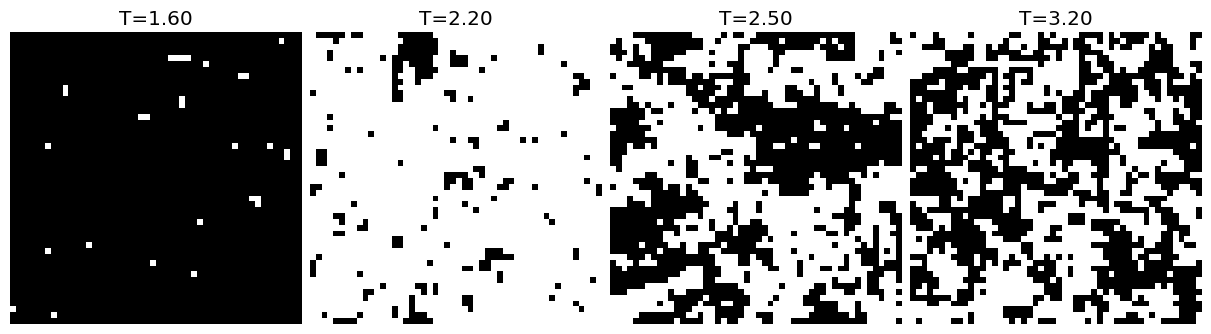

In [14]:
def snapshot_after_eq(S, T, sweeps=SWEEPS, burn=BURN, I=I, B=B, muB=muB, rng=rng):
    N = S*S
    spins = rng.choice([-1, 1], size=(S, S)).astype(np.int8)
    for s in range(sweeps):
        metropolis_sweep(spins, T=T, I=I, B=B, muB=muB, rng=rng)
    return spins.copy()

Ssnap = 50 if FAST else 80
Ts_snap = [1.6, 2.2, 2.5, 3.2]

fig, axs = plt.subplots(1, len(Ts_snap), figsize=(12, 3.2), constrained_layout=True)
for k, T in enumerate(Ts_snap):
    spins = snapshot_after_eq(Ssnap, T)
    axs[k].imshow(spins, cmap="gray", interpolation="nearest")
    axs[k].set_title(f"T={T:.2f}")
    axs[k].axis("off")
plt.show()